In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
from ATI import AboveThresholdIonization
from matplotlib.colors import LogNorm

# ATI examples
In this file we present some simple examples of how to use the ATI code to calculate PMD and spectra.

The code is made such that it should be easy for the user to implement their own fields and perform SFA calculations for those. Examples showing how to do this can be found in this file. Besides this, the class contains two standard field types, a linear and circular polarized sin^2 pulse. The parameters for this field is set through a settings dictionary, and will be the standard field type if nothing else is declared.

The code is intended to perform calculations using the saddle point approximation (SPA). It can also perform the all the SFA integrals numerically, which however will take quite some time.

If one wants efficient computation it is advised to provide the time integrals of the vector potential and the vector potential squared, needed to calculate the SFA action. If these are not provided they will be performed numerically through a simple numpy.trapz integration, slowing down compuation time by a bit.


## Sin² Linear field example (build in)

In [8]:
settings_dict = {
    'Ip': 0.5,              # Ionization potential (a.u.)
    'Wavelength': 800,      # (nm)
    'Intensity': 1e14,      # (W/cm^2)
    'cep': np.pi/2,         # Carrier envelope phase
    'N_cycles': 2,          # Nr of cycles
    'build_in_field': 'linear',   # Build in field type to use. If using other field methods leave as a empty string ''.
    'px_start': -1.5, 'px_end': 1.5,  # Momentum bounds in x direction (a.u.)
    'py_start': 0., 'py_end': 1,    # Momentum bounds in y direction (a.u.)
    'pz': 0.,               # Momentum in z direction (a.u.)
    'Nx': 200, 'Ny': 100,   # Grid resolution in the x and y direction
    'N_cores': 4,           # Nr. of cores to use in the multiprocessing calculations
    'ellipticity': None,     # The ellipticity of the laser field
    'Minimum momentum': 0.5 #
}

linear


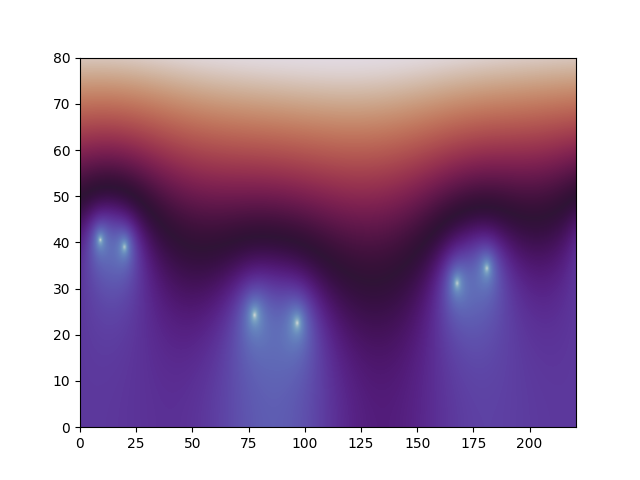

In [9]:
%matplotlib widget
ATI = AboveThresholdIonization(settings_dict=settings_dict)
ATI.get_saddle_guess([0, ATI.N_cycles * 2*np.pi/ATI.omega], [0, 80], 400, 400)

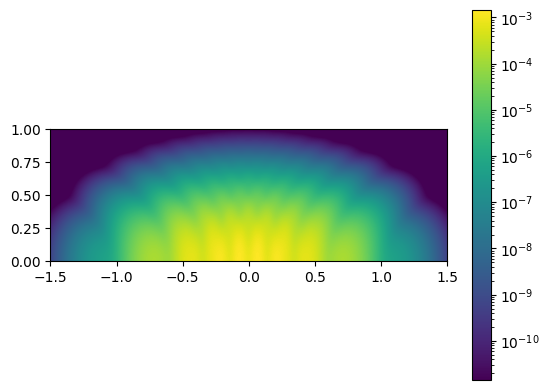

In [13]:
%matplotlib inline
PMD = ATI.calculate_PMD()
M = np.abs(PMD)**2
plt.imshow(np.flip(M,0), norm=LogNorm(vmax=np.max(M), vmin=np.max(M)*1e-8), aspect='equal',
           extent=(ATI.px_start, ATI.px_end, ATI.py_start, ATI.py_end), interpolation='bicubic')
plt.colorbar()

plt.show()

# Sin^2 circular field (build in)

# Custom field